In [ ]:
from time import time as timer
import numpy as np
from matplotlib import pyplot as plt

from npearth.earth import EARTH

In [122]:
def generate_demo_data(n_samples=400, noise_level=0.5, random_state=42):
    rng = np.random.default_rng(random_state)

    # 3 clusters: dense, medium, sparse
    n1 = int(0.55*n_samples)
    n2 = int(0.30*n_samples)
    n3 = n_samples - n1 - n2

    X = np.concatenate([
        rng.normal(-1, 0.3, n1),   # dense region
        rng.normal(1,  0.5, n2),   # medium density
        rng.normal(3,  1.0, n3),   # sparse region / tail
    ])

    X = np.sort(X)

    # Nonlinear ground truth
    f = (
        4*np.sin(X*1.2)
        + 0.5*X
        + 4*np.exp(-(X-1.2)**2)   # local bump
        - 3*np.maximum(X - 2, 0)  # piecewise drop
    )

    y = f + rng.normal(0, noise_level, n_samples)

    return X.reshape(-1, 1), y

Numba took time 0.16
sum of abs residuals MARS 58.0732


Text(0, 0.5, 'y')

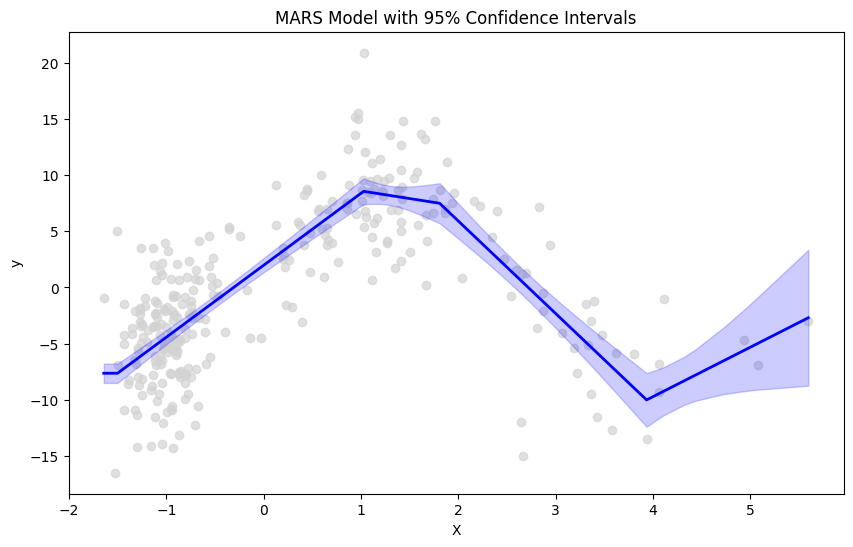

In [123]:
from sklearn.model_selection import train_test_split

# Step 2: Split Data
n = 500
X, y = generate_demo_data(n_samples=n, noise_level=4)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

model = EARTH(M_max=25, prune_model=True)
t2 = timer()
model.fit(X_train, y_train)
t3 = timer()
print(f"Numba took time {round(t3-t2,5)}")


# Step 4: Make Predictions
y_pred = model.predict(X)
y_pred_test = model.predict(X_test)

print(
    "sum of abs residuals MARS", np.sqrt(sum((y_test - y_pred_test) ** 2)).round(4)
)

# Estimate k
r = y_train - model.predict(X_train)
k = r @ r / len(y_train)

# Calculate paramater uncertainty and find epistemic uncertainty
B = np.array([basis.evaluate(X_train) for basis in model.basis_]).T
B_full = np.array([basis.evaluate(X) for basis in model.basis_]).T
vb=np.linalg.inv(B.T @ B)*k
y_var = (B_full@vb)@B_full.T

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(X_train, y_train, color="lightgray", label="Training Data",alpha=0.7)
ax.plot(X, y_pred, color="blue", label="MARS Prediction", linewidth=2)
ax.fill_between(
    X.flatten(),
    y_pred - 1.96 * np.sqrt(np.diag(y_var)),
    y_pred + 1.96 * np.sqrt(np.diag(y_var)),
    color="blue",
    alpha=0.2,
    label="95% Confidence Interval",
)
ax.set_title("MARS Model with 95% Confidence Intervals")
ax.set_xlabel("X")
ax.set_ylabel("y")